In [67]:
import tensorflow as tf

In [68]:
import numpy as np
import math

import matplotlib as mpl

import IPython.display as display
import PIL.Image
# from PIL import Image

from tensorflow.keras.preprocessing import image

In [69]:
def show(img):
  display.display(PIL.Image.fromarray(np.array(img)))

def deprocess(img):
  img = 255*(img + 1.0)/2.0
  return tf.cast(img, tf.uint8)

In [70]:
image_path = 'deep_dreaming_start/the-starry-night/the-starry-night-4k.jpg'
img = PIL.Image.open(image_path)
original_image = np.array(img)
# show(original_image)

In [71]:
from PIL import Image
def split_image(im,n):
    if math.sqrt(n).is_integer():
        M = im.shape[0]//int(math.sqrt(n))
        N = im.shape[1]//int(math.sqrt(n))
        tiles = [im[x:x+M,y:y+N] for x in range(0,im.shape[0],M) for y in range(0,im.shape[1],N)]
        return tiles
 
def get_concat_h(im1, im2):
    dst = Image.new('RGB', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst

def get_concat_v(im1, im2):
    dst = Image.new('RGB', (im1.width, im1.height + im2.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (0, im1.height))
    return dst

def concat_row(imgs):
    output = get_concat_h(imgs[0],imgs[1])
    for i in range(len(imgs)):
        if i == 0 or i == 1:
            pass
        else:
            output = get_concat_h(output,imgs[i])
    
    return output
    
def detile(imgs):
    width = int(math.sqrt(len(imgs)))
    rows = []
    for i in range(width):
        rows.append([])
        for k in range(width):
            rows[i].append(imgs[k+i*width])
    
    
    output = concat_row(rows[0])
    for i in range(width):
        if i == 0:
            pass
        else:
            output = get_concat_v(output,concat_row(rows[i]))
    
    return output


#Always make the second parameter a square number
tiles = split_image(original_image,25)

# outputs = []
# for tile in tiles:
#     outputs.append(PIL.Image.fromarray(tile, mode='RGB'))

# out   = detile(outputs)

# out.show()
# for tile in tiles:
#     show(tile)

In [72]:
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

# Maximize the activations of these layers
# names = ['mixed3', 'mixed5']

names = ['mixed2']
layers = [base_model.get_layer(name).output for name in names]

# Create the feature extraction model
dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)

In [73]:
def calc_loss(img, model):
  # Pass forward the image through the model to retrieve the activations.
  # Converts the image into a batch of size 1.
  img_batch = tf.expand_dims(img, axis=0)
  layer_activations = model(img_batch)
  if len(layer_activations) == 1:
    layer_activations = [layer_activations]

  losses = []
  for act in layer_activations:
    loss = tf.math.reduce_mean(act)
    losses.append(loss)

  return  tf.reduce_sum(losses)

In [74]:
class DeepDream(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(
      input_signature=(
        tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
        tf.TensorSpec(shape=[], dtype=tf.int32),
        tf.TensorSpec(shape=[], dtype=tf.float32),)
  )
  def __call__(self, img, steps, step_size):
      print("Tracing")
      loss = tf.constant(0.0)
      for n in tf.range(steps):
        with tf.GradientTape() as tape:
          # This needs gradients relative to `img`
          # `GradientTape` only watches `tf.Variable`s by default
          tape.watch(img)
          loss = calc_loss(img, self.model)

        # Calculate the gradient of the loss with respect to the pixels of the input image.
        gradients = tape.gradient(loss, img)

        # Normalize the gradients.
        gradients /= tf.math.reduce_std(gradients) + 1e-8 

        # In gradient ascent, the "loss" is maximized so that the input image increasingly "excites" the layers.
        # You can update the image by directly adding the gradients (because they're the same shape!)
        img = img + gradients*step_size
        img = tf.clip_by_value(img, -1, 1)

      return loss, img

In [75]:
def run_deep_dream_simple(img, steps=100, step_size=0.01):
  # Convert from uint8 to the range expected by the model.
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  img = tf.convert_to_tensor(img)
  step_size = tf.convert_to_tensor(step_size)
  steps_remaining = steps
  step = 0
  while steps_remaining:
    if steps_remaining>100:
      run_steps = tf.constant(100)
    else:
      run_steps = tf.constant(steps_remaining)
    steps_remaining -= run_steps
    step += run_steps

    loss, img = deepdream(img, run_steps, tf.constant(step_size))

    display.clear_output(wait=True)
    show(deprocess(img))
    print ("Step {}, loss {}".format(step, loss))


  result = deprocess(img)
  display.clear_output(wait=True)
  show(result)

  return result

In [76]:
deepdream = DeepDream(dream_model)

In [77]:
def octaves(img=img,steps = 50,step_size = 0.01):
    OCTAVE_SCALE = 1.30

    img = tf.constant(np.array(img))
    base_shape = tf.shape(img)[:-1]
    float_base_shape = tf.cast(base_shape, tf.float32)

    for n in range(-2, 0):
      new_shape = tf.cast(float_base_shape*(OCTAVE_SCALE**n), tf.int32)

      img = tf.image.resize(img, new_shape).numpy()

      img = run_deep_dream_simple(img=img, steps=steps, step_size=step_size)

    display.clear_output(wait=True)
    img = tf.image.resize(img, base_shape)
    img = tf.image.convert_image_dtype(img/255.0, dtype=tf.uint8)
    show(img)
    
    return img

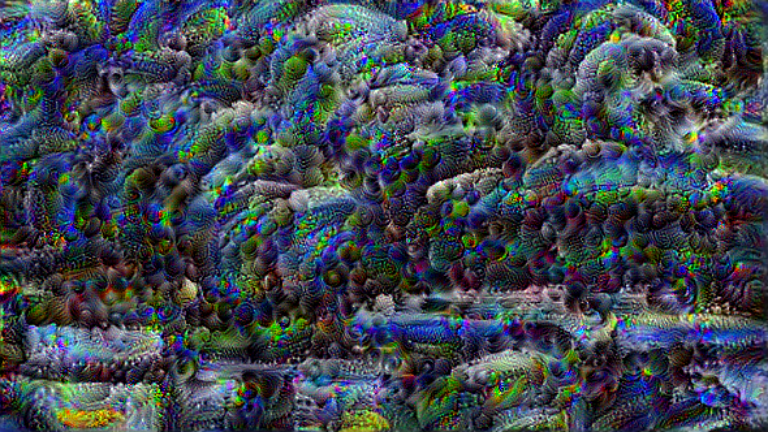

73.68622398376465

In [78]:
import time
import random
start = time.time()

outputs = []
for tile in tiles:
    dream_img = octaves(img=tile, steps=100, step_size=0.01)
    
    result = np.clip(dream_img, 0.0, 255.0)
    result = result.astype(np.uint8)
    
    outputs.append(PIL.Image.fromarray(result, mode='RGB'))

count = random.randint(0, 1024)
result = detile(outputs)
result.save("OutputDreams/your_file_{}.jpg".format(count))

end = time.time()
end-start